In [1]:
import sys

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.bioqc
%aimport pygenesig.tools
%aimport pygenesig.perfmeasures
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
from pygenesig.tools import * 
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd
import sklearn.metrics as skm 
import os.path
import dask
from distributed import Client, progress
import dask.async
import dask.diagnostics

import seaborn as sns
sns.set_style("ticks", {"axes.grid" : True})
from pylab import * 

# Create signature from fantom5

## tissue

In [2]:
expr = np.load("../data/f5/tissue_exprs.npy")
target = np.genfromtxt("../data/f5/tissue_target.csv", delimiter=",", dtype=str)
gene_ids = pd.read_csv("../data/f5/tissue_gene_ids.csv", header=None, index_col=0)

In [3]:
rosetta = dict(enumerate(gene_ids.iloc[:,0]))

In [4]:
sg = GiniSignatureGenerator(expr[:, :], target, aggregate_fun=np.sum)

In [5]:
signatures = sg.mk_signatures()

In [6]:
signatures_id = {
    tissue : [
        rosetta[gene] for gene in genes
    ] for tissue, genes in signatures.items()
}

In [7]:
write_gmt(signatures_id, "../results/f5/tissue.gmt")

## primary cells

In [8]:
expr = np.load("../data/f5/primary_exprs.npy")
target_fine = np.genfromtxt("../data/f5/primary_target_fine.csv", delimiter=",", dtype=str)
target_coarse = np.genfromtxt("../data/f5/primary_target_coarse.csv", delimiter=",", dtype=str)
gene_ids = pd.read_csv("../data/f5/primary_gene_ids.csv", header=None, index_col=0)

In [10]:
rosetta = dict(enumerate(gene_ids.iloc[:,0]))

In [11]:
sg_fine = GiniSignatureGenerator(expr[:, :], target_fine, aggregate_fun=np.sum)
sg_coarse = GiniSignatureGenerator(expr[:, :], target_coarse, aggregate_fun=np.sum)

In [12]:
signatures_fine = sg_fine.mk_signatures()

In [13]:
signatures_coarse= sg_coarse.mk_signatures()

In [14]:
signatures_fine_id = {
    tissue : [
        rosetta[gene] for gene in genes
    ] for tissue, genes in signatures_fine.items()
}

In [15]:
signatures_coarse_id = {
    tissue : [
        rosetta[gene] for gene in genes
    ] for tissue, genes in signatures_coarse.items()
}

### merge fine to form coarse signatures again

In [25]:
signatures_coarse_merged = {tissue: [] for tissue in signatures_coarse_id}

for tissue_fine, genes_fine  in signatures_fine_id.items(): 
    tissue_coarse = tissue_fine.split("-")[0].strip()
    signatures_coarse_merged[tissue_coarse].extend(genes_fine)
    
signatures_coarse_merged = {
    tissue: set(genes) for tissue, genes in signatures_coarse_merged.items()
}

### write results to gmt

In [26]:
write_gmt(signatures_fine_id, "../results/f5/primary_fine.gmt")
write_gmt(signatures_coarse_id, "../results/f5/primary_coarse.gmt")
write_gmt(signatures_coarse_merged, "../results/f5/primary_coarse_merged.gmt")

### compare merged vs. direct computation

In [29]:
def jaccard_mat(sigs1, sigs2):
    for name1, genes1 in sigs1.items():
        for name2, genes2 in sigs2.items():
            yield (name1, name2, jaccard_ind(set(genes1), set(genes2)))

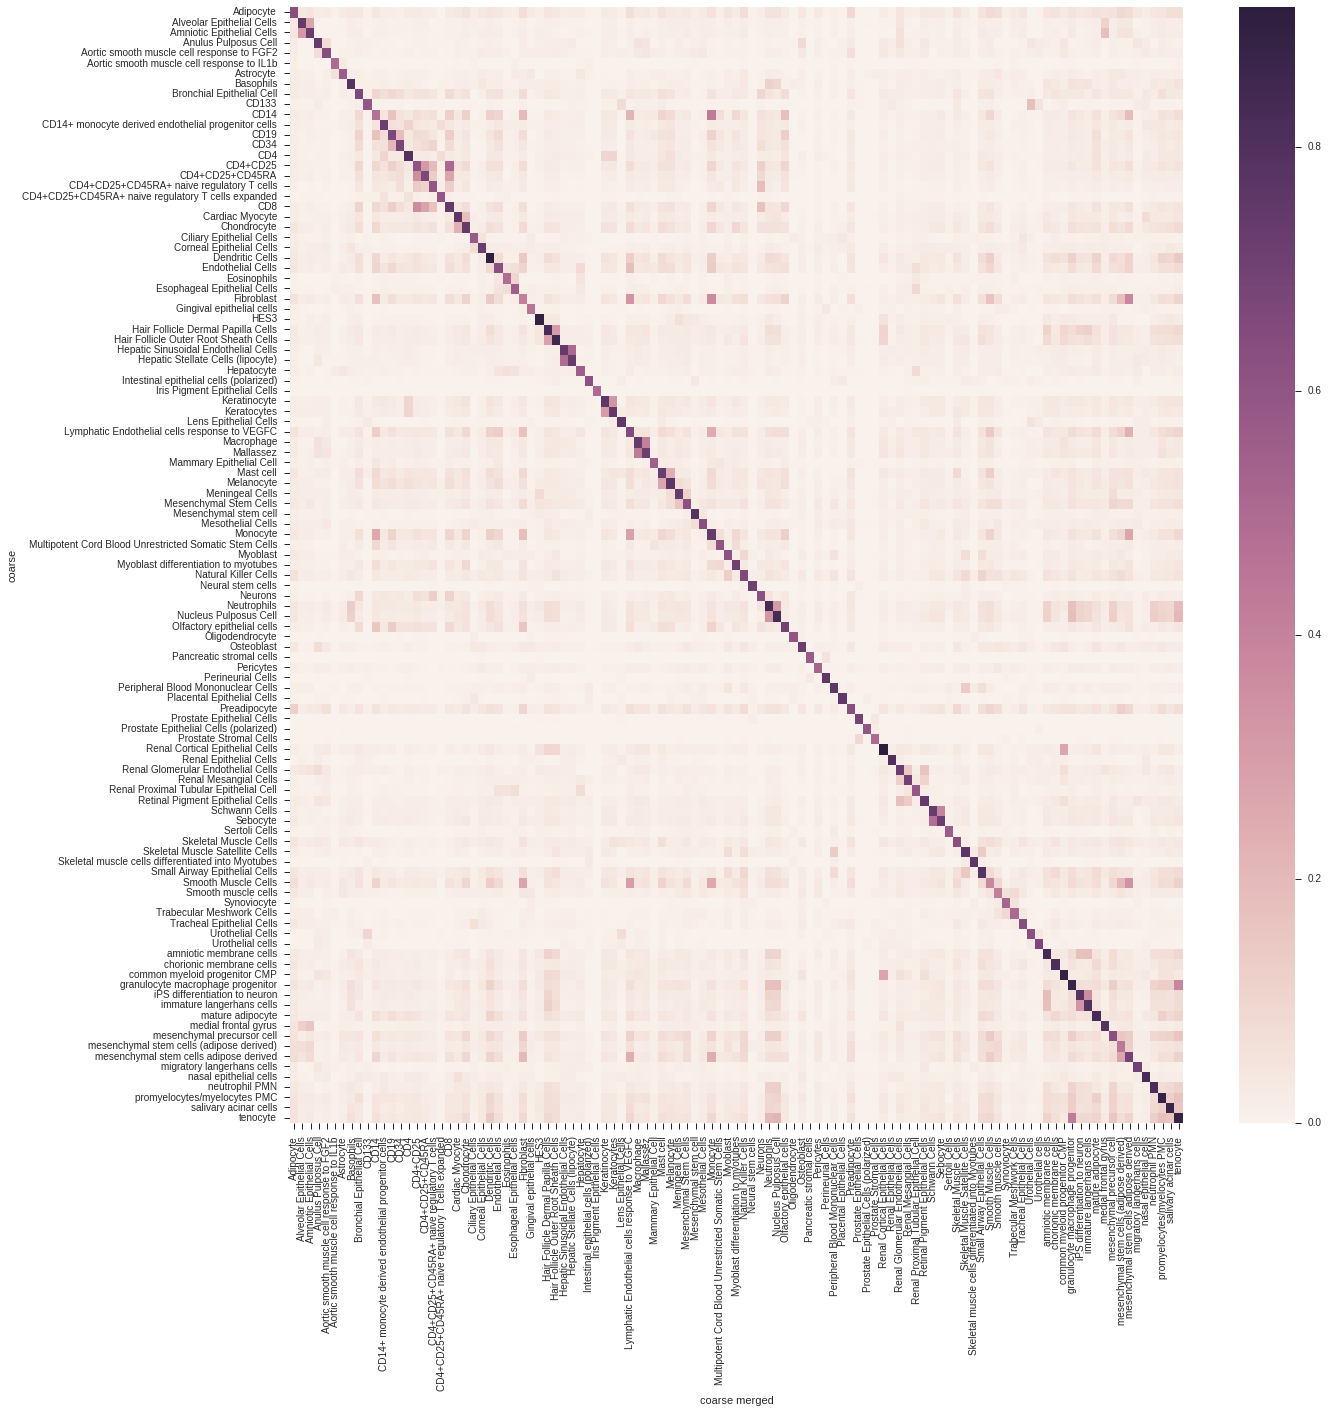

In [31]:
fig, ax = subplots(figsize=(20, 20))
df = pd.DataFrame(jaccard_mat(signatures_coarse_id, signatures_coarse_merged), columns=("coarse", "coarse merged", "jaccard"))
sns.heatmap(df.pivot(*df.columns), ax=ax)